In [2]:
#!pip install -r requirements.txt
!pip install lightgbm

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import recmetrics
import sys
import pprint
import tqdm
import re
import lightgbm


from prediction import LtrPrediction
from processing import DataPreprocessing
import ltr_utils as ut

## Data Sampling

In [4]:
dv_train = pd.read_csv('recsys_data/train.csv')
x = dv_train[dv_train['response'] == 1].groupby('ip').size().reset_index(name='num_clicks').sort_values(by=['num_clicks'], ascending=False)['ip'].head(100)
df_ip = pd.DataFrame({'ip':x})
dv_train = pd.merge(dv_train,df_ip,on='ip')

In [5]:
dv_train.nunique()

ip            100
event_date     10
tcm_id         66
response        2
dtype: int64

In [6]:
len(dv_train)

8090

In [7]:
dv_test = pd.read_csv('recsys_data/test_all.csv')
dv_test = pd.merge(dv_test,df_ip,on='ip')

In [8]:
dv_test = dv_test.drop(['Unnamed: 0'], axis=1)
dv_test.nunique()

ip            100
event_date      1
tcm_id         66
response        2
dtype: int64

In [9]:
len(dv_test)

6600

In [10]:
dv_test = dv_test.head(1000)
dv_train = dv_train.head(1000)

In [11]:
dv_train.to_csv('outputs/sample_train.csv')
dv_test.to_csv('outputs/sample_test.csv')

## Data Preprocessing

In [12]:
data_dict = {
    'train' : 'outputs/sample_train.csv',
    'test' : 'outputs/sample_test.csv',
    'articles' : 'recsys_data/articles.csv',
    'users' : 'recsys_data/users.csv'
}

In [13]:
DataPrep = DataPreprocessing(data_dict)

(458, 19) (869, 19)


In [14]:
DataPrep.init_KG('outputs/KGs/KG_dep_parsing_100terms.txt')

In [15]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [16]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 869/869 [00:06<00:00, 142.11it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 458/458 [00:03<00:00, 130.22it/s]


In [17]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg','st'])

(869, 151) (869, 1) (458, 151) (458, 1)


In [18]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [23]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y_test = y_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

test_data =  test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="map",
    verbose_eval=False
)

model.fit(
    X=X_train,
    y=y_train,
    group=groups_train,
    eval_set=[(X_train,y_train),(X_test, y_test)],
    eval_group=[groups_train,groups_test],
    eval_at = [10],
    verbose= False
)


train_score = np.mean(model.evals_result_['training']['map@10'])
test_score = np.mean(model.evals_result_['valid_1']['map@10'])

print('default Train :  ',train_score)
print('default Test  :  ',test_score)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_eval
default Train :   0.9681772893772893
default Test  :   0.14922910840262033


## Hyperparameter Tuning

In [24]:
def objective(trial):

        metric = "map@10"

        param_grid = {
            #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
            "max_bin": trial.suggest_int("max_bin", 200, 300),
            "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
            "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
            "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        }

        model = lightgbm.LGBMRanker(
            objective="lambdarank",
            metric="map",
            verbose_eval=False,
            **param_grid
        )
        
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "map@10")

        model.fit(
            X=X_train,
            y=y_train,
            group=groups_train,
            eval_set=[(X_test, y_test)],
            eval_group=[groups_test],
            eval_at = [10],
            verbose= False,
            early_stopping_rounds=100,
            callbacks=[
                pruning_callback
            ],  # Add a pruning callback
        )


        test_score = np.mean(model.evals_result_['valid_0']['map@10'])


        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return test_score

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=500)

/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=step
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [25]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.3601
Best params:
	n_estimators: 10000
	learning_rate: 0.29674196195261576
	num_leaves: 1960
	max_depth: 4
	min_data_in_leaf: 8500
	max_bin: 253
	lambda_l1: 100
	lambda_l2: 80
	min_gain_to_split: 6.287724673040316
	bagging_fraction: 0.9
	bagging_freq: 1
	feature_fraction: 0.7


In [27]:
metric = "map@10"

bst_model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="map",
    verbose_eval=False,
    **study.best_params
)
bst_model.fit(
        X=X_train,
        y=y_train,
        group=groups_train,
        eval_set=[(X_train,y_train),(X_test, y_test)],
        eval_group=[groups_train,groups_test],
        eval_at = [10],
        verbose= False
    )

result = bst_model.evals_result_
train_score = np.mean(result['training']['map@10'])
test_score = np.mean(result['valid_1']['map@10'])
print('Optimized Train :  ',train_score)
print('Optimized Test  :  ',test_score)

Optimized Train :   0.08914224664224665
Optimized Test  :   0.36010247385991434


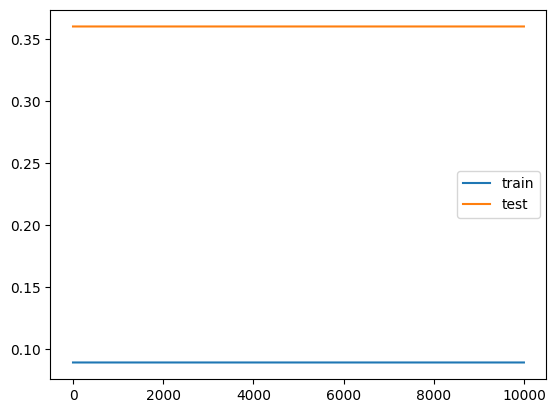

In [28]:
# plot learning curves
pyplot.plot(result['training']['map@10'], label='train')
pyplot.plot(result['valid_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

## Model Evaluation

In [30]:
xgb_Prediction = LtrPrediction(bst_model, test_data)

In [31]:
results = xgb_Prediction.evaluate()
results

{'MAP@10': 0.06498677248677248,
 'Prediction_Coverage': 19.61,
 'Catalog_Coverage': 19.61,
 'Novelty': 1.6826322863696577,
 'personalization': 1.1102230246251565e-16}

In [32]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [33]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [34]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

,article_actual_ids,article_recomended_ids,apk
ip,,,
47811,"[tcm:526-10787, tcm:526-670542, tcm:526-18025, tcm:526-684643, tcm:526-191289, tcm:526-239640, tcm:526-244935, tcm:526-418532]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.225000
2227897,"[tcm:526-492865, tcm:526-187302, tcm:526-695181, tcm:526-231792, tcm:526-276414, tcm:526-40469, tcm:526-46242]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.176190
1523358,"[tcm:526-10838, tcm:526-656536, tcm:526-681575, tcm:526-688510, tcm:526-707567, tcm:526-224772, tcm:526-22867, tcm:526-46242]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.154167
503477,"[tcm:526-656536, tcm:526-12180, tcm:526-674187, tcm:526-681575, tcm:526-16645, tcm:526-208086, tcm:526-209028, tcm:526-22867, tcm:526-273898, tcm:526-40469]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.150000
1602525,"[tcm:526-116442, tcm:526-16645, tcm:526-187302, tcm:526-209028, tcm:526-224772, tcm:526-249037, tcm:526-40469, tcm:526-46242]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.091667
60747,"[tcm:526-551763, tcm:526-12174, tcm:526-149043, tcm:526-681575, tcm:526-682576, tcm:526-18025, tcm:526-93195, tcm:526-259315, tcm:526-276414]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.087302
1356756,"[tcm:526-13782, tcm:526-16645, tcm:526-684643, tcm:526-199040, tcm:526-231792, tcm:526-80807, tcm:526-40469]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.047619
2068384,"[tcm:526-13782, tcm:526-695181, tcm:526-208086, tcm:526-93195, tcm:526-259315, tcm:526-346380, tcm:526-388698, tcm:526-46242]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.025000
223190,"[tcm:526-551763, tcm:526-191289, tcm:526-707567, tcm:526-22867, tcm:526-231792, tcm:526-244935, tcm:526-249037, tcm:526-276414]","[tcm:526-10787, tcm:526-681575, tcm:526-40469, tcm:526-418532, tcm:526-46242, tcm:526-492865, tcm:526-551763, tcm:526-653510, tcm:526-656536, tcm:526-670542]",0.017857
